# BLINK

## **IMPORTS**
\
Dans cette partie nous importons les bibliothèques necessaires au projet, nous importons l'extrait sonore et nous introduisons quelque variables utiles pour la suite.

https://musicandcomputersbook.com

In [1]:
#Imports des bibliothèques
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import sonagramme as son

In [2]:
# Charger le fichier audio
filename = 'fichiers_audio/voix_4_notes.wav'
#  sr pour sample rate
sr, y = wavfile.read(filename)  # sr est le taux d'échantillonnage, y est le signal audio en tant que array
print(sr)

# Variables utiles pour la suite
taille_extrait = len(y)
y_min, y_max = np.min(y), np.max(y)  # valeurs min et max prises par les amplitudes du signal
T = [i * sr for i in range(len(y))]  # Liste des abscisses (temps) de chaque point de y

48000


In [33]:
# Création du signal test constant


#--------- ACTIVER POUR LES FONCTIONS TEST ----------#

fonction_test = True

#----------------------------------------------------#


f1_test = 5000 # fréquence du signal
f2_test = 2000
sr = 48000 # sample rate du signal
t_test = 1 # durée en secondes du signal
N_test = t_test*sr # nombre de points du signal
A_test = 20000 # amplitude du signal

if fonction_test == True:
    T = [i/sr for i in range(N_test)]
    y = []
    for i in range(24000):
        y.append( A_test*np.sin(2*np.pi*f1_test*(i/sr)) + (A_test/2)*np.sin(2*np.pi*f1_test*2*(i/sr)) )
    for i in range(24000):
        y.append( A_test*np.sin(2*np.pi*f2_test*(i/sr)) + (A_test/2)*np.sin(2*np.pi*f2_test*2*(i/sr)) )

    

## **AFFICHAGE DE L'EXTRAIT EN TEMPOREL ET FRÉQUENTIEL**
\
Dans cette partie nous allons créer les fonctions necessaires à l'import de l'extrait audio, et les fonctions necessaires au passage temporel/fréquentiel grâce à la FFT (Fast Fourier Transform). Nous vérifierons que les fonctions sont complémentaires et fonctionnent ensemble, c'est à dire que IFFT(FFT(y)) = y et FFT(IFFT(Y)) = Y.

In [34]:
# Fonction pour calculer la transformée de Fourier d'un extrait
def TF_extrait(extrait, sr):
    Y = np.fft.fft(extrait)
    L_freqs = np.fft.fftfreq(len(Y), 1/sr)
    return Y, L_freqs


# Fonction pour calculer la transformée de Fourier inverse d'un spectre
def ITF_extrait(spectre):
    extrait = np.fft.ifft(spectre)
    return extrait

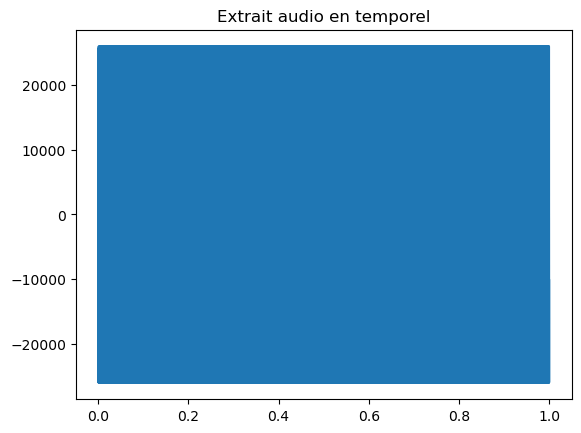

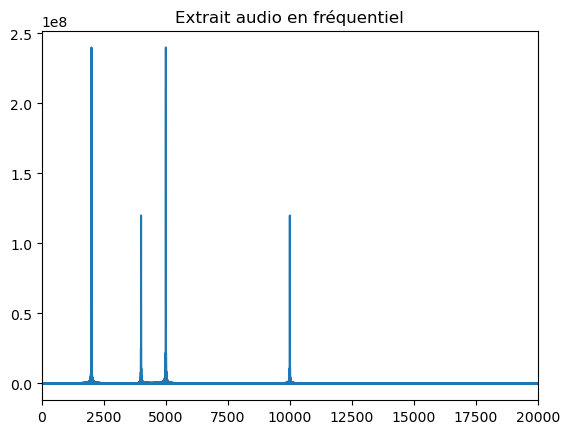

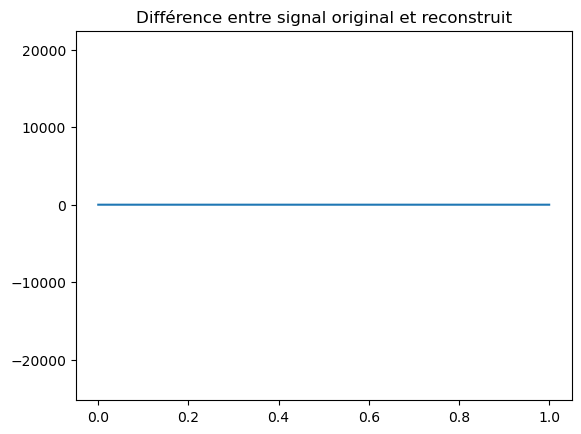

In [35]:
# Affichage du signal temporel
plt.figure(1)
plt.title("Extrait audio en temporel")
plt.plot(T, y)

# Affichage du signal en fréquentiel
Y, freqs = TF_extrait(y, sr)
plt.figure(2)
plt.xlim(0,20000)
plt.title("Extrait audio en fréquentiel")
plt.plot(freqs, np.abs(Y))

y_reconstruit = ITF_extrait(Y)
diff = y_reconstruit - y
plt.figure(3)
plt.title("Différence entre signal original et reconstruit")
plt.plot(T, diff)
plt.ylim([y_min, y_max])

plt.show()

(C'est normal si le spectre ne ressemble à rien, ce n'est pas un signal périodique au global)

Les fonctions de calcul de FFT et IFFT fonctionnent correctement, et la dernière figure montre que les deux fonctions sont bien inverses l'unes de l'autres. En réalité la différence ne fait pas exactement 0, il y a une erreur de l'ordre de 10e-12 venant des approximations de calcul. Ces erreurs sont fortement négligeables devant l'amplitude de l'information dans le signal réel.

Le sonagramme a été mis en échelle log sur les fréquences, pour mieux voir les distinctions en basses fréquences (plus représentées pour un signal sonore).


Une bibliothèque de fonctions a été créée pour contruire et afficher les sonagrammes à partir d'un signal et de données d'échantillonage. voir le programme "sonagramme.py".

## **CRÉATION DU SONAGRAMME**
\
Le but est de créer un sonagramme : pour un extrait sonore complexe qui contient plus qu'une note, ça n'a pas de sens de regarder la répartition fréquetielle du signal total puisque le but est de trouver à chaque instant quelles sont les notes jouées. Nous allons alors découper le signal en segments suffisamment petits pour que le son y soit considéré stationnaire. Ensuit nous pourrons regarder la transformée de Fourier sur chaque semgent, pour savoir à chaque instant quelles sont les notes perçues.\
Nous pourrons ensuite regarder l'évolution temporelle de la répatition fréquentielle, c'est à dire tracer la répartition fréquentielle pour chaque segment du son considéré.

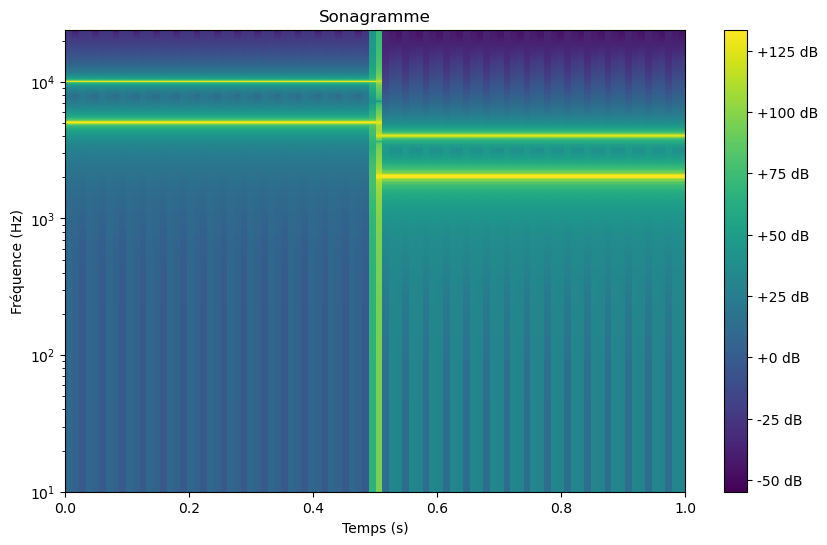

In [41]:
# Paramètres pour le découpage du signal
window_size = 1024  # Taille de chaque segment en nombre d'échantillons
hop_size = 512  # Décalage entre les segments en nombre d'échantillons

# Calcul du spectrogramme
sonagramme = son.calculer_sonagramme(y, sr, window_size, hop_size)

# Afficher le sonagramme
son.afficher_sonagramme(sonagramme, sr, len(y), window_size, hop_size)

In [23]:
# TODO :  VÉRIFIER QUE LE SONAGRAMME FONCTIONNE BIEN, AVEC DES SIGNAUX HARMONIQUES SIMPLES

## **EXTRACTION DU SON**
\
Dans cette partie nous allons extraire la fréquence fontamentale à chaque instant, dans le but d'obtenir la (ou les) note.s pure.s émise.s par l'instrument et ensuite pouvoir lui appliquer les modulations voulues pour transformer l'instrument en synthétiseur.\
Ici l'algorithme utilisé est très simple : on cherche simplement la fréquence qui possède la puissance maximale, par simple itération sur le tableau de données.

In [37]:
def extraction_fonda(spectro, sr, window_size): 
    L_freq_fonda = []
    resolution = sr / window_size  # Résolution fréquentielle
    nb_temps = len(spectro)
    
    for i in range(nb_temps):
        spectre = spectro[i]  # Spectre à l'instant i
        nb_freq = len(spectre)
        freq_fonda_index = 0
        for j in range(nb_freq):
            if spectre[j] > spectre[freq_fonda_index]:
                freq_fonda_index = j
        freq_fonda = freq_fonda_index * resolution  # Convertir l'indice en Hz
        L_freq_fonda.append(freq_fonda)
        
    return L_freq_fonda

# Extraction des fréquences fondamentales : à chaque pas de temps, donne la fréquence fondamentale.
# Le nombre d'elements de la liste est donc le nombre de pas de temps.
L_freq_fonda = extraction_fonda(sonagramme, sr, window_size)
print(L_freq_fonda)




[5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 5015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625, 2015.625]


Nous allons également nous interesser à d'autres manières de procéder pour détecter des fréquences dans un signal. La première méthode est intuitive et fonctionne bien pour une seule fréquence, mais elle devient fastidieuse pour le traitement des signaux polyphoniques, ce que nous aimerions faire ici.\
Nous allons dans un premier temps nous interesser à deux méthodes : premièrement l'algorithme Yin (ref : http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf) et pYin (ref : https://www.eecs.qmul.ac.uk/~simond/pub/2014/MauchDixon-PYIN-ICASSP2014.pdf), puis la méthode par réseau de neurones convolutifs CREPE (ref : https://arxiv.org/abs/1802.06182).

## **RECONSTRUCTION DU SON**
\
Dans cette partie nous allons reconstruire un signal monochromatique issu de la fréquence fondamentale principale extraite dans la partie précédente.\
\
La partie précédente nous a fourni une liste qui à chaque pas de temps nous donne la fréquence fondamentale trouvée (on pourra par la suite étendre l'étude à un signal polychromatique et chaque élement de la liste sera une liste de plusieurs fréquences). Donc puisqu'à chaque instant on connait la fréquence jouée, on peut reconstruire un signal chromatique simple (donc sans aucunes harmoniques) sur chaque fenêtre d'étude.

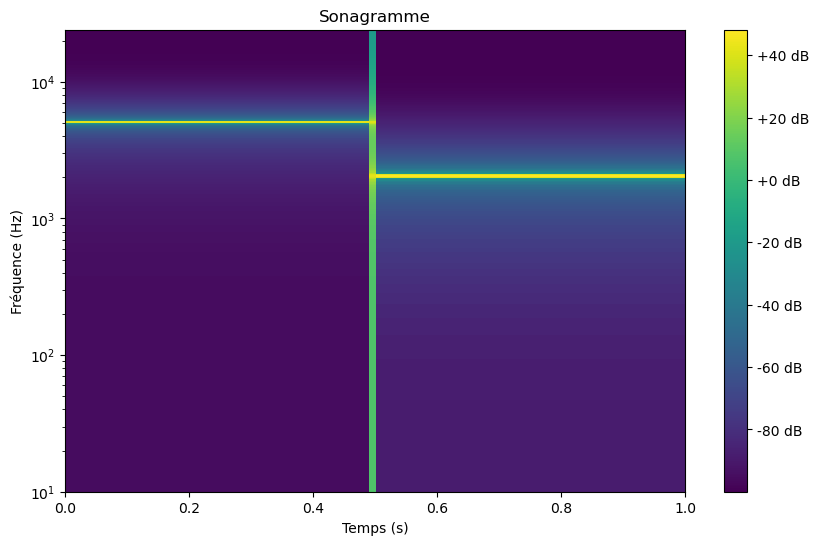

In [38]:
# Création d'une sinusoïde de fréquence f
def sinusoïde(f,t):
    res = np.sin(2*np.pi*f*t)
    return res

def reconstruction(spectrogram):
    L_freq_fonda = extraction_fonda(spectrogram, sr, window_size)
    signal_reconstruit = []
    # Nb est le nombre de points d'échantillonage
    Nb = len(L_freq_fonda)
    for i in range(Nb):
        # f est la fréquence détéctée pour la ième fenêtre d'étude
        f = L_freq_fonda[i]
        for j in range(hop_size):
            # Pour avoir t, on se place à la ième fenêtre et au jème point de la fenêtre
            t = (i*hop_size)/sr + j/sr
            val = sinusoïde(f,t)
            signal_reconstruit.append(val)
    for k in range(hop_size):
        t = k/sr
        f = L_freq_fonda[Nb-1]
        val = sinusoïde(f,t)
        signal_reconstruit.append(val)
    return signal_reconstruit

sig = reconstruction(sonagramme)
# Calcul du spectrogramme
sonagramme_2 = son.calculer_sonagramme(sig, sr, window_size, hop_size)

# Afficher le sonagramme
son.afficher_sonagramme(sonagramme_2, sr, len(y), window_size, hop_size)




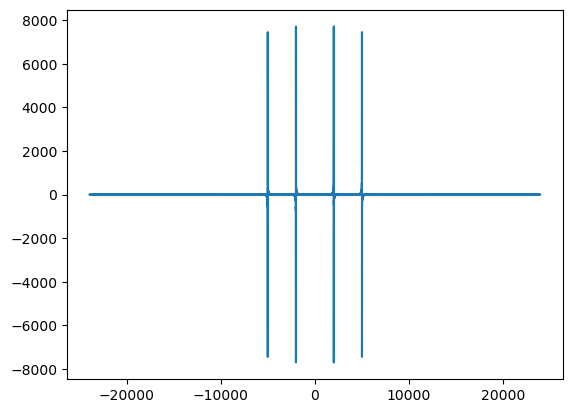

In [39]:
# On affiche enfin le signal reconstruit :
Y_rec, L_freq_rec = TF_extrait(sig,sr)
plt.plot(L_freq_rec,Y_rec)
plt.show()

Le signal n'est pas correct !!! À cause de la numérisation, il faut faire intervenir du sinus cardinal (transformée de fourier inverse de la fenêtre d'échantillonage). Après ça, la reconstruction devrait être bonne ?

## **SIMULATION DE PÉDALES D'EFFETS**
\
Dans cette partie nous allons essayer de reproduire les effets produits par des pédales, que ce soit des effets agissant sur le spectre ou sur le signal lui même.

In [1]:
def Filtre(signal):
    return

# Reverb 
Pour simuler une reverb il existe plusieurs méthodes plus ou moins sophistiquées. La première méthode, simpliste et peu concluante, consiste en simplement executer un écho à forte vitesse. Mais le résultat sera peu esthétique. Il existe une méthode bien plus efficace permettant de simuler la rverbération produite par un certain lieu, méthode qu'on appelle éreverbération par convolution". 

Mathématiquement, lorsque l'on joue un son dans un lieu, disons dans une église (lieux connus pour leur excellente réverbération), l'église va agir comme un certain filtre sur le signal. Appelelons, en domaine temporel, $x$ le signal d'entrée, $y$ le signal de sortie et $h$ le filtre.
Alors dans le domaine fréquentiel, en notant respectivement $X$, $Y$ et $H$ leur transformées de Fourier, nous avons :
$$HX = Y$$
Dans le domaine temporel, cela revient à écrire :
$$h*x = y$$
où $*$ est l'opération de convolution sur les signaux. H est un filtre fréquentiel mais peut être également interprété comme un certain signal, qui représente "l'empreinte" qu'aurait le lieu sur le signal d'entrée : cette emprunte, $h$, est ce qu'on appelle la réponse impultionnelle du filtre. 
Il suffit alors d'avoir l'emprunte impultionnelle d'un lieu, sous forme de signal sonore donc, et de le convolutionner à un signal sonore pour faire "agir" le lieu sur le signal, comme si le signal avait été joué dans ce lieu !


In [2]:
def Reverb(signal):
    return